In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44291/status,
Dashboard: /proxy/44291/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44231,Workers: 7
Dashboard: /proxy/44291/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:43665,Total threads: 4
Dashboard: /proxy/36389/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:33935,


In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

0.3.0


In [4]:
%%time
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

u_along_da_mean.load()
u_along_da_seasonal.load()
u_along_da_annual.load()
u_along_da_monthly.load()
CSHT_months.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428)>
array([[[-5.01025119e+09, -3.71894267e+09, -5.73132132e+09, ...,
         -1.90749223e+10, -2.01919225e+10, -2.06019626e+10],
        [-8.25905744e+09, -7.24946920e+09, -9.17167711e+09, ...,
         -2.16314000e+10, -2.25934516e+10, -2.29391463e+10],
        [-1.07717302e+10, -1.00464920e+10, -1.18972073e+10, ...,
         -2.38190501e+10, -2.46215919e+10, -2.48813804e+10],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-6.89040991e+08,  9.67616762e+08, -3.42201050e+08, ...,
         -8.89954582e+09, -9.44438376e+09, -1.00079570e+10],
        [-4.38763652e+09, -3.10446942e+09, -4.38369446e+09, ...,
         -1.02565513e+10, -1.08542582e+10, -1.14239085e+10],
        [-6.77400417e+09, -5.66592811e+09, -6.94417618e+09, ...,
         -1.14995682e+10, -1.21039216e+10, -1.26527639e+10],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-3.82070145e+09, -3.19849214e+09, -4.71941600e+09, ...,
         -2.12435439e+09, -3.97971090e+09, -4.52681419e+09],
        [-5.43568471e+09, -5.01545418e+09, -6.45645441e+09, ...,
         -4.04930558e+09, -5.83974656e+09, -6.29130308e+09],
        [-6.59039149e+09, -6.35147193e+09, -7.75300173e+09, ...,
         -5.75343039e+09, -7.45653266e+09, -7.81667912e+09],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31

In [27]:
## GMM doesn't accept any NaNs - so, we need to drop all NaNs in depth space and normalise onto a sigma co-ordinate (between 0 and 1)
depths_2d_da = u_along_da_mean.st_ocean
depths_2d_da = depths_2d_da.expand_dims(dim={'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints.size},axis=1)\
.assign_coords({'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints})
depths_2d_da = (depths_2d_da*u_along_da_mean/u_along_da_mean).rename('depth')

# Calculate the values of M and O, the columns and rows of U_along
n_rows = u_along_da_mean.shape[0]
o_cols = u_along_da_mean.shape[1]
m_rows = n_rows // o_cols

reshaped_u_along_df_season = []
reshaped_u_along_df_annual = []
reshaped_u_along_df_monthly = []
reshaped_CSHT_df_monthly = []

# Reshape the DataFrame to an MxO shape, and drop NaNs from the depth axis
reshaped_u_along_df = pd.DataFrame(np.array(u_along_da_mean).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_u_along_df = reshaped_u_along_df.dropna(how='all', axis=0)
for i in tqdm(range(12)):
    tmp = (pd.DataFrame(np.array(u_along_da_seasonal)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_seasonal.st_ocean, columns=u_along_da_seasonal.lon_bin_midpoints))
    reshaped_u_along_df_season.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_annual.year.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_annual)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_annual.st_ocean, columns=u_along_da_annual.lon_bin_midpoints))
    reshaped_u_along_df_annual.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_monthly.time.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_monthly)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_monthly.st_ocean, columns=u_along_da_monthly.lon_bin_midpoints))
    reshaped_u_along_df_monthly.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(CSHT_months.time.size)):
    tmp = (pd.DataFrame(np.array(CSHT_months.where(CSHT_months!=0))[i,:,:].reshape(n_rows, o_cols), index=CSHT_months.depth, columns=CSHT_months.lon))
    reshaped_CSHT_df_monthly.append(tmp.dropna(how='all', axis=0))

## Do the same for the depth array
reshaped_depths_df = pd.DataFrame(np.array(depths_2d_da).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_depths_df = reshaped_depths_df.dropna(how='all', axis=0)

100%|██████████| 732/732 [07:15<00:00,  1.68it/s]


In [49]:
## GMM doesn't accept any NaNs - so, we need to drop all NaNs in depth space and normalise onto a sigma co-ordinate (between 0 and 1)
depths_2d_da = CSHT_months.depth
depths_2d_da = depths_2d_da.expand_dims(dim={'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints.size},axis=1)\
.assign_coords({'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints})
depths_2d_da = (depths_2d_da*CSHT_months.where(CSHT_months!=0)/CSHT_months.where(CSHT_months!=0)).rename('depth')


MemoryError: Unable to allocate 61.1 TiB for an array with shape (75, 1428, 732, 75, 1428) and data type float64

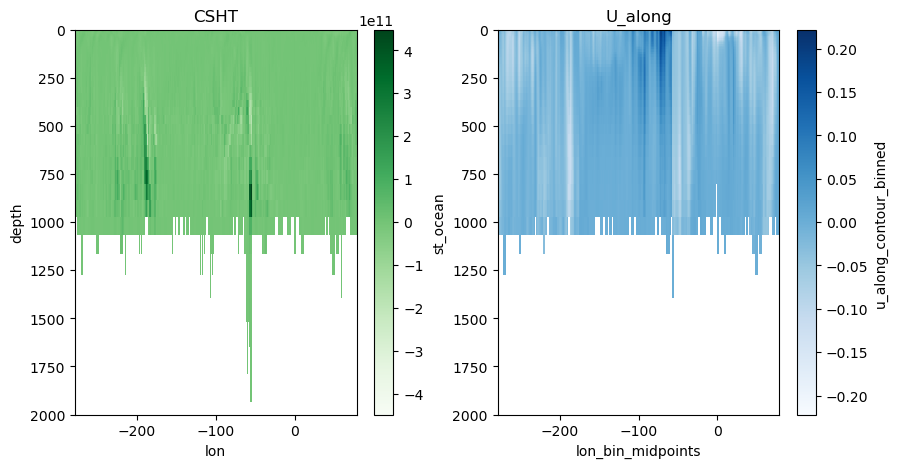

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)


CSHT_months.where(CSHT_months!=0).isel(time=0).plot(ax=axs[0], cmap = plt.cm.Greens)
axs[0].invert_yaxis()
axs[0].set_ylim(2000,0)
axs[0].set_title('CSHT')
u_along_da_monthly.isel(time=0).plot(ax=axs[1], cmap = plt.cm.Blues)
axs[1].invert_yaxis()
axs[1].set_ylim(2000,0)
axs[1].set_title('U_along')
plt.show()

In [29]:
## Create sigma bins for interpolation
normalised_depths_df = reshaped_depths_df/reshaped_depths_df.max(skipna=True, axis=0)
depth_bins = reshaped_depths_df.index/reshaped_depths_df.index[-1]

In [30]:
%%time
## Interpolate onto a uniform [0,1] sigma co-ordinate for all profiles
import scipy.interpolate as interpolate

# new_u_along = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
# new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
# new_u_along_season_list = []
# new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
# new_u_along_annual_list = []
# new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
# new_u_along_monthly_list = []
new_CSHT_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_CSHT_monthly_list = []

# for i in tqdm(range(normalised_depths_df.keys().size)):
#         f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df[normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
#         new_u_along[:,i] = f_values_u_along(depth_bins)

# for j in tqdm(range(12)):
#     new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
#     for i in (range(normalised_depths_df.keys().size)):
#         f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_season[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
#         new_u_along_season[:,i] = f_values_u_along(depth_bins)
#     new_u_along_season_list.append(new_u_along_season)

# for j in tqdm(range(u_along_da_annual.year.size)):
#     new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
#     for i in (range(normalised_depths_df.keys().size)):
#         f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_annual[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
#         new_u_along_annual[:,i] = f_values_u_along(depth_bins)
#     new_u_along_annual_list.append(new_u_along_annual)

# for j in tqdm(range(u_along_da_monthly.time.size)):
#     new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
#     for i in (range(normalised_depths_df.keys().size)):
#         f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_monthly[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
#         new_u_along_monthly[:,i] = f_values_u_along(depth_bins)
#     new_u_along_monthly_list.append(new_u_along_monthly)

for j in tqdm(range(CSHT_months.time.size)):
    new_CSHT_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_CSHT= interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_CSHT_df_monthly[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_CSHT_monthly[:,i] = f_values_CSHT(depth_bins)
    new_CSHT_monthly_list.append(new_CSHT_monthly)

  0%|          | 0/732 [00:00<?, ?it/s]


ValueError: x and y arrays must be equal in length along interpolation axis.

In [31]:
reshaped_u_along_df_monthly[j][normalised_depths_df.keys()[i]].values

array([-0.02359511, -0.01865366, -0.01603528, -0.01404351, -0.01211246,
       -0.00990959, -0.00724368, -0.00454195, -0.00335686, -0.0034619 ,
       -0.00254393, -0.00172042, -0.00272747, -0.00382487, -0.00430555,
       -0.00470692, -0.00514227, -0.00570022, -0.00640022, -0.00724393,
       -0.00823543, -0.00938955, -0.01072542, -0.01226955, -0.01404705,
       -0.01608043, -0.01835165, -0.0207663 , -0.02310602, -0.02510566,
       -0.02655513, -0.02747512, -0.02803128, -0.02848071, -0.02910557,
       -0.03017   , -0.03091958, -0.0293898 , -0.02910739, -0.02803054,
       -0.02754718, -0.02584947, -0.02345267, -0.01887141, -0.01388467,
       -0.01239625, -0.00769041,         nan,         nan,         nan])

In [33]:
reshaped_CSHT_df_monthly[j][normalised_depths_df.keys()[i]].shape

(54,)

In [16]:
## Define the dataframe that will be fed into the GMM -  we are dropping NaNs
new_u_along_df = pd.DataFrame(new_u_along, index=depth_bins, columns=normalised_depths_df.keys())
new_u_along_df = new_u_along_df.dropna(how='all', axis=1)

new_u_along_df_season = []
new_u_along_df_annual = []
new_u_along_df_monthly = []
new_CSHT_df_monthly = []

for j in tqdm(range(12)):
    tmp = pd.DataFrame(new_u_along_season_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_season.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_annual.year.size)):
    tmp = pd.DataFrame(new_u_along_annual_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_annual.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_monthly.time.size)):
    tmp = pd.DataFrame(new_u_along_monthly_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_monthly.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(CSHT_months.time.size)):
    tmp = pd.DataFrame(new_CSHT_monthly_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_CSHT_df_monthly.append(tmp.dropna(how='all', axis=1))

  0%|          | 0/732 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:
# Convert into DataArrays
u_along_da = xr.DataArray(new_u_along_df.values, \
                              coords={'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_seasons = xr.DataArray(np.array(new_u_along_df_season), coords={'month':u_along_da_seasonal.month.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'month':u_along_da_seasonal.month.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_yearly = xr.DataArray(np.array(new_u_along_df_annual), coords={'year':u_along_da_annual.year.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'year':u_along_da_annual.year.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_months = xr.DataArray(np.array(new_u_along_df_monthly), coords={'time':u_along_da_monthly.time.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'time':u_along_da_monthly.time.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')

In [ ]:
u_along_da_months

In [10]:
# Define the surface, depth u_along that will be fed into the GMM
surf_u_along_da = u_along_da.sel(depth=slice(0,0.3))
deep_u_along_da = u_along_da.sel(depth=slice(0.3, None))

surf_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0,0.3))
deep_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0.3, None))

surf_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0,0.3))
deep_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0.3, None))

surf_u_along_da_months = u_along_da_months.sel(depth=slice(0,0.3))
deep_u_along_da_months = u_along_da_months.sel(depth=slice(0.3, None))

## CHECK: Note the depth-averaging below is NOT weighted - as it turns out this doesn't 
## make a difference to the regime definitions

surf_u_along_da_avg = surf_u_along_da.mean('depth')
deep_u_along_da_avg = deep_u_along_da.mean('depth')

surf_u_along_da_seasons_avg = surf_u_along_da_seasons.mean('depth')
deep_u_along_da_seasons_avg = deep_u_along_da_seasons.mean('depth')

surf_u_along_da_annual_avg = surf_u_along_da_annual.mean('depth')
deep_u_along_da_annual_avg = deep_u_along_da_annual.mean('depth')

surf_u_along_da_months_avg = surf_u_along_da_months.mean('depth')
deep_u_along_da_months_avg = deep_u_along_da_months.mean('depth')

## 'result' is the array that is fed into GMM

result_mean = xr.concat([(surf_u_along_da_avg/surf_u_along_da_avg.std()-deep_u_along_da_avg/deep_u_along_da_avg.std()),\
                     ((u_along_da/abs(u_along_da)).isel(depth=0))\
                         /((u_along_da/abs(u_along_da)).isel(depth=0)).std()], dim='loc')
result_seasons = xr.concat([(surf_u_along_da_seasons_avg/surf_u_along_da_seasons_avg.std()-deep_u_along_da_seasons_avg/deep_u_along_da_seasons_avg.std()),\
                     ((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0))\
                            /((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0)).std()], dim='loc')
result_annual = xr.concat([(surf_u_along_da_annual_avg/surf_u_along_da_annual_avg.std()-deep_u_along_da_annual_avg/deep_u_along_da_annual_avg.std()),\
                     ((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0))\
                            /((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0)).std()], dim='loc')
result_months = xr.concat([(surf_u_along_da_months_avg/surf_u_along_da_months_avg.std()-deep_u_along_da_months_avg/deep_u_along_da_months_avg.std()),\
                     ((u_along_da_months/abs(u_along_da_months)).isel(depth=0))\
                            /((u_along_da_months/abs(u_along_da_months)).isel(depth=0)).std()], dim='loc')



In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

n_clusters = []
labels_gmm = []
centers_gmm = []
probs_gmm = []

aic_gmm = []
bic_gmm = []
silhouette_gmm = []

X = result_mean.T

k_clusters = range(1,22)
# We are varying number of clusters to see which is optimal using some diagnostics like AIC, BIC etc. 
for k in tqdm(k_clusters):
    n_clusters.append(k)
    # This is the GMM model definition
    gmm = GaussianMixture(n_components=k, random_state=42)
    # Labels is the actual mask that is produced
    labels_gmm.append(gmm.fit_predict(X))
    centers_gmm.append(gmm.means_)
    probs_gmm.append(gmm.predict_proba(X))
    aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))
    if k>=3:
        silhouette_gmm.append(silhouette_score(X, labels_gmm[k-2], metric='euclidean'))


100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


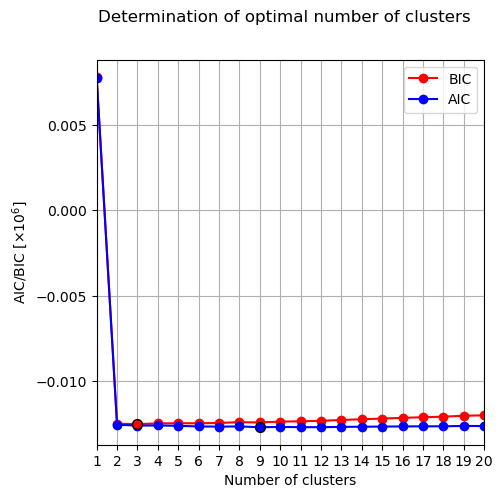

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# axs = axs.ravel()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)

axs.plot(n_clusters, np.array(bic_gmm)/10**6, 'r-o', label='BIC')
axs.plot(n_clusters, np.array(aic_gmm)/10**6, 'b-o', label='AIC')
axs.scatter(n_clusters[np.argmin(aic_gmm)], aic_gmm[np.argmin(aic_gmm)]/10**6, 50, color='blue', ec='k', zorder=10000)
axs.scatter(n_clusters[np.argmin(bic_gmm)], bic_gmm[np.argmin(bic_gmm)]/10**6, 50, color='red', ec='k', zorder=10000)

axs.set_xticks(n_clusters)
axs.set_xlabel('Number of clusters')
axs.set_xlim(1,20)
axs.grid()
axs.set_ylabel(r'AIC/BIC [$\times10^6$]')
axs.legend()

plt.suptitle('Determination of optimal number of clusters', fontsize=12)
plt.show()

In [13]:
# Note: Optimal n is 1 less than the actual number of clusters, so n_optimal = 2 implies 3 clusters, etc. 
n_optimal = 2

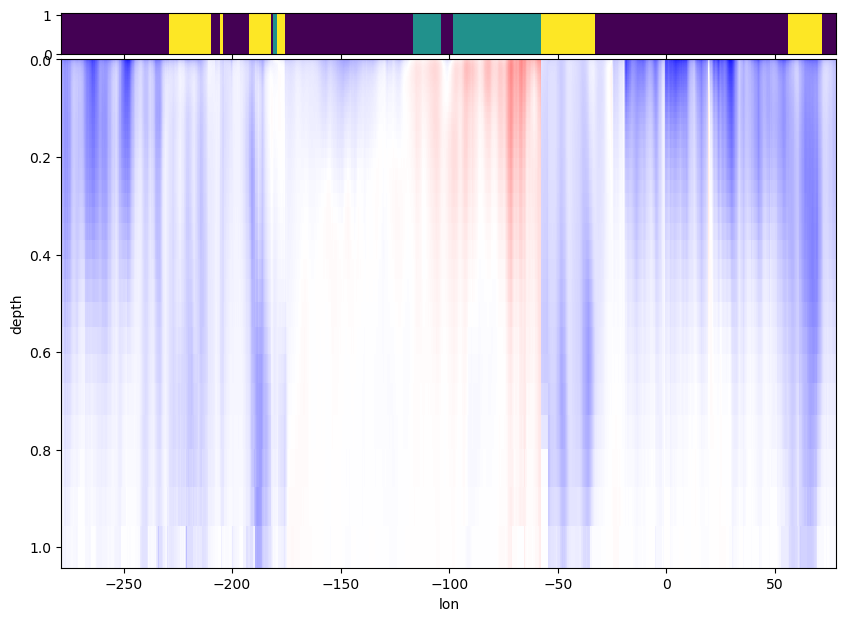

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.02, wspace=0.02)

axs[0].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm[n_optimal][:,np.newaxis], depth_bins.size, axis=-1).T)
u_along_da.plot(ax=axs[1], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
axs[1].invert_yaxis()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
labels_gmm_seasons = []
for i in tqdm(range(12)):
    Y = result_seasons.isel(month=i).T
    gmm = GaussianMixture(n_components=3, random_state=37)
    labels_gmm_seasons.append(gmm.fit(X).predict(Y))

100%|██████████| 12/12 [00:00<00:00, 100.30it/s]


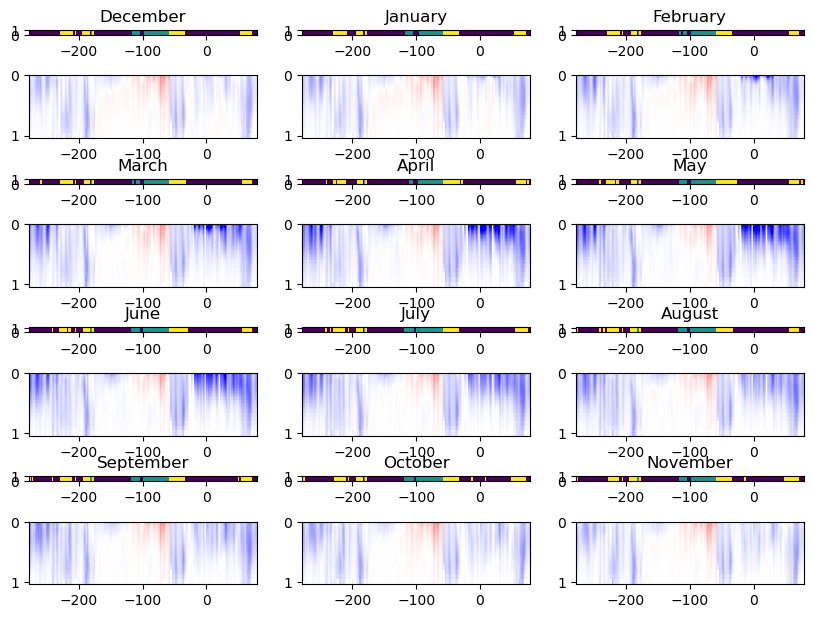

In [17]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons.isel(month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_seasons.png', dpi=300, bbox_inches='tight')
plt.show()

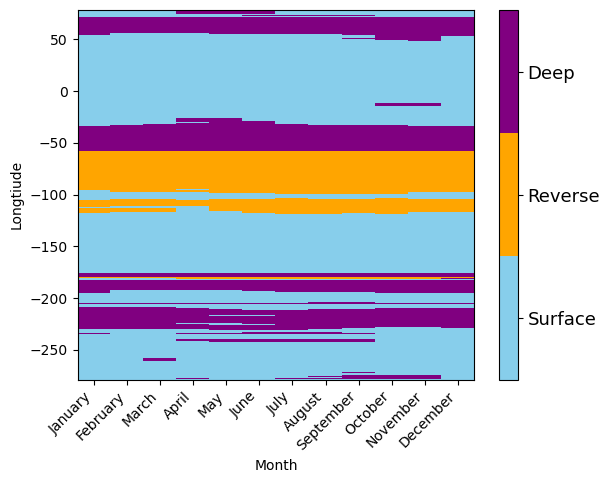

In [18]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

plt.pcolor(months,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_seasons).T, cmap=cmap)
plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Month')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_season_labels.png', dpi=300, bbox_inches='tight')
plt.show()

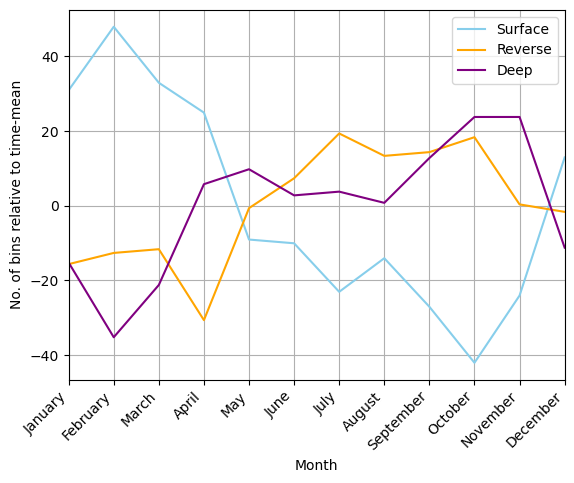

In [19]:
cnt_szn = np.zeros((3,12))
for j in range(3):
    for i in range(12):
        cnt_szn[j,i] = labels_gmm_seasons[i].tolist().count(j)

    plt.plot(cnt_szn[j,:]-np.nanmean(cnt_szn[j,:]), c = colors[j], label = classes[j])
plt.gca().set_xticks(np.arange(0,12))
plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Month')
plt.xlim(0,11)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
labels_gmm_annual = []
for i in tqdm(range(u_along_da_yearly.year.size)):
    Y = result_annual.isel(year=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_annual.append(gmm.fit(X).predict(Y))

100%|██████████| 61/61 [00:00<00:00, 98.32it/s] 


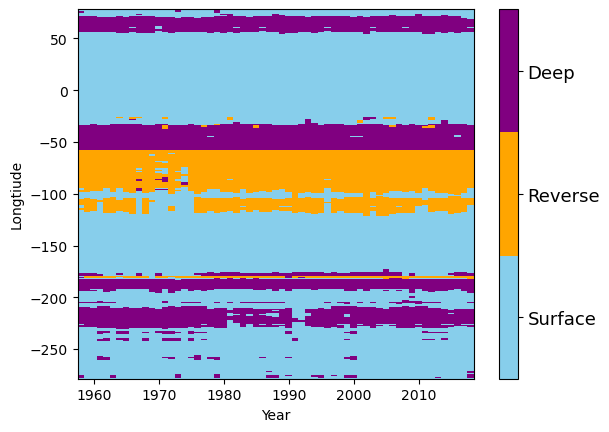

In [21]:
plt.pcolor(u_along_da_annual.year,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_annual).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_annual_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 61/61 [00:00<00:00, 43438.46it/s]


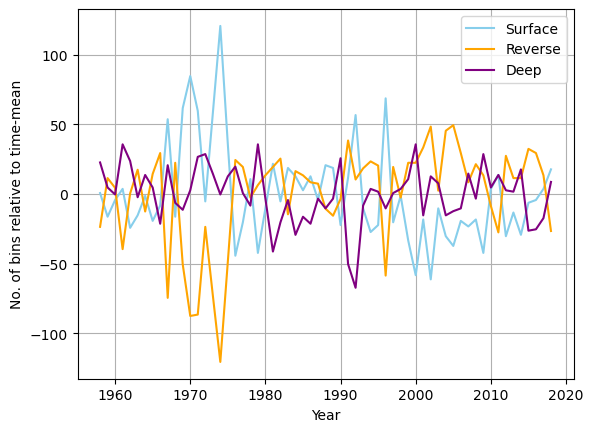

In [22]:
cnt_anno = np.zeros((3,u_along_da_yearly.year.size))
for j in range(3):
    for i in tqdm(range(u_along_da_yearly.year.size)):
        cnt_anno[j,i] = labels_gmm_annual[i].tolist().count(j)

    plt.plot(u_along_da_yearly.year, cnt_anno[j,:]-np.nanmean(cnt_anno[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_annual.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
labels_gmm_months = []
for i in tqdm(range(u_along_da_monthly.time.size)):
    Y = result_months.isel(time=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_months.append(gmm.fit(X).predict(Y))

100%|██████████| 732/732 [00:07<00:00, 98.33it/s] 


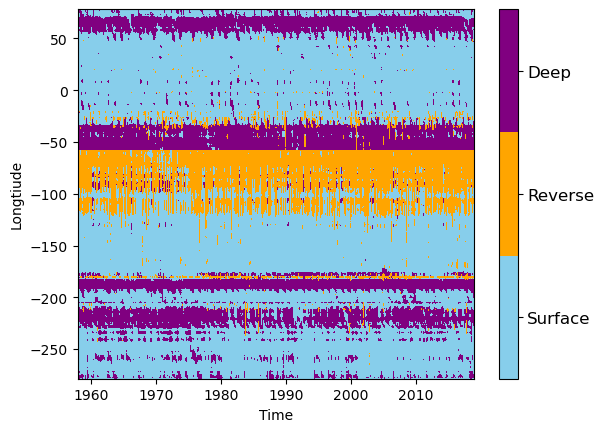

In [24]:
plt.pcolor(np.arange(u_along_da_months.time.size)/12+1958,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_months).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_monthly_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 732/732 [00:00<00:00, 44521.90it/s]


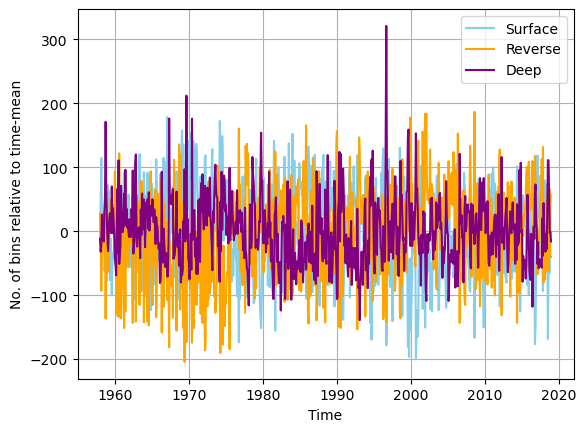

In [25]:
cnt_monthly = np.zeros((3,u_along_da_monthly.time.size))
for j in range(3):
    for i in tqdm(range(u_along_da_monthly.time.size)):
        cnt_monthly[j,i] = labels_gmm_months[i].tolist().count(j)

    plt.plot(np.arange(u_along_da_months.time.size)/12+1958, cnt_monthly[j,:]-np.nanmean(cnt_monthly[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_monthly.png', dpi=300, bbox_inches='tight')
plt.show()

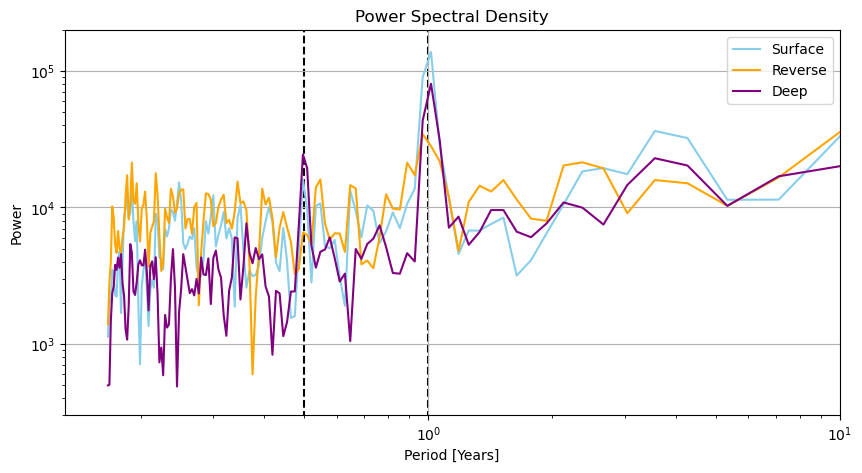

In [26]:
from scipy import signal
# Plot the power spectral density
plt.figure(figsize=(10, 5))

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(cnt_monthly[j,:], fs=1)
    plt.loglog(1/frequencies/12, psd, c = colors[j], label = classes[j])

plt.title('Power Spectral Density')
plt.vlines(0.5,1e2,1e6, color='black', linestyle='dashed', zorder=-1)
plt.vlines(1,1e2,1e6, color='black', linestyle='dashed', zorder=-1)

plt.ylim(3e2,2e5)
plt.xlabel('Period [Years]')
plt.ylabel('Power')
plt.xlim(0,10)
plt.grid()
plt.legend()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/monthly_power_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

## Assess u_along and CSHT in regimes

In [53]:
u_along_da_months

<xarray.DataArray 'u_along' (time: 732, depth: 50, lon: 1428)>
array([[[-2.41512505e-02, -2.53141471e-02, -2.71286635e-02, ...,
         -2.13019750e-02, -2.12939936e-02, -2.42385012e-02],
        [-2.03805232e-02, -2.15273411e-02, -2.33570227e-02, ...,
         -1.56291167e-02, -1.61242928e-02, -1.92330961e-02],
        [-1.74836281e-02, -1.86175112e-02, -2.04593774e-02, ...,
         -1.12298639e-02, -1.21098935e-02, -1.53471571e-02],
        ...,
        [-1.37447594e-02, -1.64740483e-02, -1.99580649e-02, ...,
          7.54880513e-03,  6.96407861e-03,  6.50884668e-03],
        [-1.21601336e-02, -1.33050032e-02, -1.65665607e-02, ...,
          8.17600713e-03,  7.06450704e-03,  6.54470767e-03],
        [-7.69041461e-03, -7.69041461e-03, -1.97410406e-02, ...,
          9.09924510e-03,  7.55561789e-03,  6.00420839e-03]],

       [[-6.95812736e-02, -6.94430484e-02, -6.92384926e-02, ...,
         -2.14513272e-02, -2.22694314e-02, -2.74808033e-02],
        [-6.49204059e-02, -6.46157087e-02, -6.43041539e-02, ...,
         -1.68478918e-02, -1.83484073e-02, -2.37572094e-02],
        [-6.11239740e-02, -6.06905456e-02, -6.03008310e-02, ...,
         -1.31095788e-02, -1.51367600e-02, -2.06932626e-02],
...
        [ 1.74807547e-03,  8.13840461e-04, -5.76590569e-05, ...,
         -2.69198821e-04,  1.53414688e-04, -1.77524814e-04],
        [ 2.06459089e-03,  1.04687390e-03,  2.27448865e-04, ...,
          2.86730892e-03,  2.45170242e-03,  2.04619574e-03],
        [-2.28664364e-03, -2.28664364e-03, -6.26145126e-03, ...,
          6.64320063e-03,  6.02350810e-03,  4.89517056e-03]],

       [[-3.83355830e-02, -3.75660001e-02, -3.68432016e-02, ...,
         -3.85011513e-02, -3.47670561e-02, -3.70554387e-02],
        [-3.34539298e-02, -3.26422913e-02, -3.19143137e-02, ...,
         -3.23212778e-02, -2.94558316e-02, -3.19867435e-02],
        [-2.92739596e-02, -2.84286000e-02, -2.76972509e-02, ...,
         -2.71685187e-02, -2.50348116e-02, -2.77616197e-02],
        ...,
        [-4.32106108e-03, -6.34935630e-03, -8.86236543e-03, ...,
          7.99613401e-03,  6.95845702e-03,  6.12253446e-03],
        [-3.45398754e-03, -4.92851560e-03, -7.18474128e-03, ...,
          9.61904445e-03,  7.93991175e-03,  6.95473972e-03],
        [-3.02981356e-03, -3.02981356e-03, -1.00399572e-02, ...,
          1.14995330e-02,  9.52918678e-03,  7.39279321e-03]]])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * depth    (depth) float64 0.000406 0.001261 0.002205 ... 0.8365 0.9154 1.0
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25

In [54]:
## Convert the mask with label numbers to an array
labels_masks_mean = np.ones((3, np.array(labels_gmm[n_optimal]).shape[0]))*np.nan

for i in range(3):
    labels_masks_mean[i,:] = np.ma.where(np.array(labels_gmm[n_optimal])==i, 1, np.nan)

clustering_mask_mean = xr.DataArray(labels_masks_mean, dims = {'regime':np.arange(3).size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes,  \
                                                     'lon':u_along_da_months.lon})

In [56]:
# ds = xr.Dataset()
# ds['regimes_mask'] = clustering_mask_mean

# ds.to_netcdf('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

In [27]:
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

In [28]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regime: 3)>
array([[[[        nan,         nan, -0.02359511],
         [        nan,         nan, -0.02475564],
         [        nan,         nan, -0.02657239],
         ...,
         [-0.0204653 ,         nan,         nan],
         [-0.02053152,         nan,         nan],
         [-0.02350026,         nan,         nan]],

        [[        nan,         nan, -0.01865366],
         [        nan,         nan, -0.01979311],
         [        nan,         nan, -0.02162974],
         ...,
         [-0.01303114,         nan,         nan],
         [-0.01375674,         nan,         nan],
         [-0.01694079,         nan,         nan]],

        [[        nan,         nan, -0.01603528],
         [        nan,         nan, -0.01716227],
         [        nan,         nan, -0.01901062],
         ...,
...
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

In [29]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [30]:
CSHT_along_monthly

<xarray.Dataset>
Dimensions:                              (time: 732, st_ocean: 75,
                                          lon_bin_midpoints: 1428,
                                          contour_index: 6002)
Coordinates:
  * st_ocean                             (st_ocean) float64 0.5413 ... 5.709e+03
  * contour_index                        (contour_index) int64 1 2 ... 6001 6002
  * lon_bin_midpoints                    (lon_bin_midpoints) float64 -278.5 ....
    TLON                                 (contour_index) float32 dask.array<chunksize=(6002,), meta=np.ndarray>
    TLAT                                 (contour_index) float32 dask.array<chunksize=(6002,), meta=np.ndarray>
    ULON                                 (contour_index) float32 dask.array<chunksize=(6002,), meta=np.ndarray>
    ULAT                                 (contour_index) float32 dask.array<chunksize=(6002,), meta=np.ndarray>
  * time                                 (time) datetime64[ns] 1958-01-31 ......
Data variables:
    zonal_convergence                    (time, st_ocean, lon_bin_midpoints) float64 dask.array<chunksize=(1, 75, 1428), meta=np.ndarray>
    binned_cross_slope_heat_trans        (time, st_ocean, lon_bin_midpoints) float64 dask.array<chunksize=(1, 75, 1428), meta=np.ndarray>
    unbinned_heat_transp_across_contour  (time, st_ocean, contour_index) float32 dask.array<chunksize=(1, 75, 6002), meta=np.ndarray>
    lat_along_contour                    (st_ocean, time, contour_index) float64 dask.array<chunksize=(75, 1, 6002), meta=np.ndarray>
    lon_along_contour                    (st_ocean, time, contour_index) float64 dask.array<chunksize=(75, 1, 6002), meta=np.ndarray>
    lat_bin_midpoints                    (st_ocean, time, lon_bin_midpoints) float64 dask.array<chunksize=(75, 1, 1428), meta=np.ndarray>

In [31]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regime: 3)>
array([[[[            nan,             nan, -5.01025119e+09],
         [            nan,             nan, -3.71894267e+09],
         [            nan,             nan, -5.73132132e+09],
         ...,
         [-1.90749223e+10,             nan,             nan],
         [-2.01919225e+10,             nan,             nan],
         [-2.06019626e+10,             nan,             nan]],

        [[            nan,             nan, -8.25905744e+09],
         [            nan,             nan, -7.24946920e+09],
         [            nan,             nan, -9.17167711e+09],
         ...,
         [-2.16314000e+10,             nan,             nan],
         [-2.25934516e+10,             nan,             nan],
         [-2.29391463e+10,             nan,             nan]],

        [[            nan,             nan, -1.07717302e+10],
         [            nan,             nan, -1.00464920e+10],
         [            nan,             nan, -1.18972073e+10],
         ...,
...
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

In [32]:
masked_CSHT

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regime: 3)>
array([[[[            nan,             nan, -5.01025119e+09],
         [            nan,             nan, -3.71894267e+09],
         [            nan,             nan, -5.73132132e+09],
         ...,
         [-1.90749223e+10,             nan,             nan],
         [-2.01919225e+10,             nan,             nan],
         [-2.06019626e+10,             nan,             nan]],

        [[            nan,             nan, -8.25905744e+09],
         [            nan,             nan, -7.24946920e+09],
         [            nan,             nan, -9.17167711e+09],
         ...,
         [-2.16314000e+10,             nan,             nan],
         [-2.25934516e+10,             nan,             nan],
         [-2.29391463e+10,             nan,             nan]],

        [[            nan,             nan, -1.07717302e+10],
         [            nan,             nan, -1.00464920e+10],
         [            nan,             nan, -1.18972073e+10],
         ...,
...
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

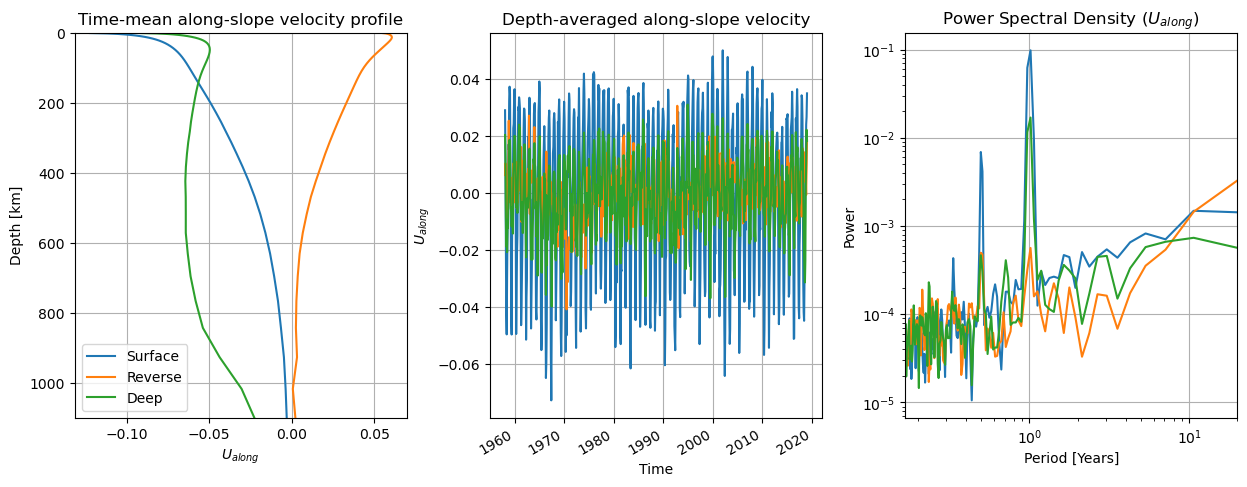

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_along.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_along.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_along.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_along.isel(regime=0).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
(masked_u_along.isel(regime=1).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
(masked_u_along.isel(regime=2).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_along.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters.png', dpi=300, bbox_inches='tight')
plt.show()



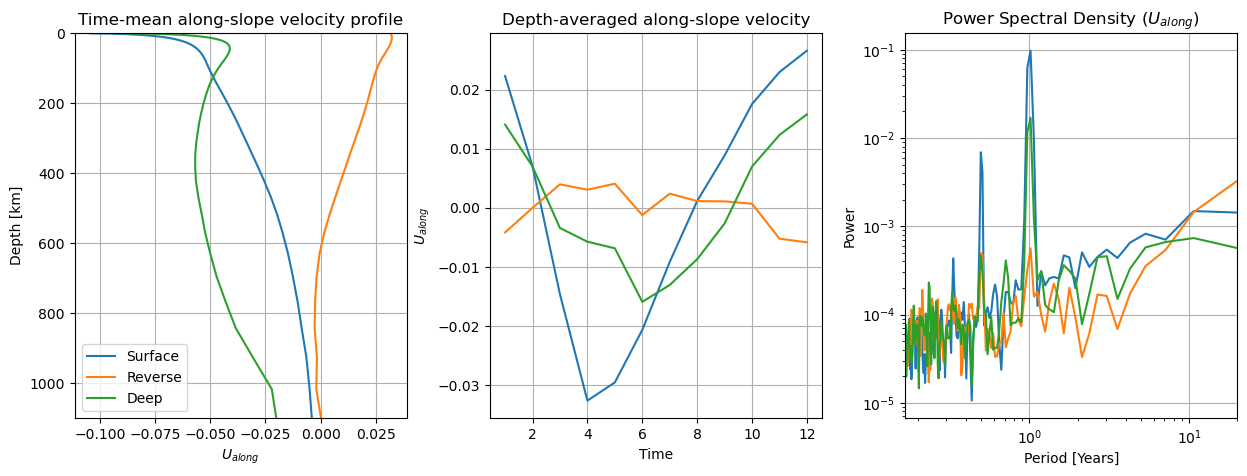

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_along.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


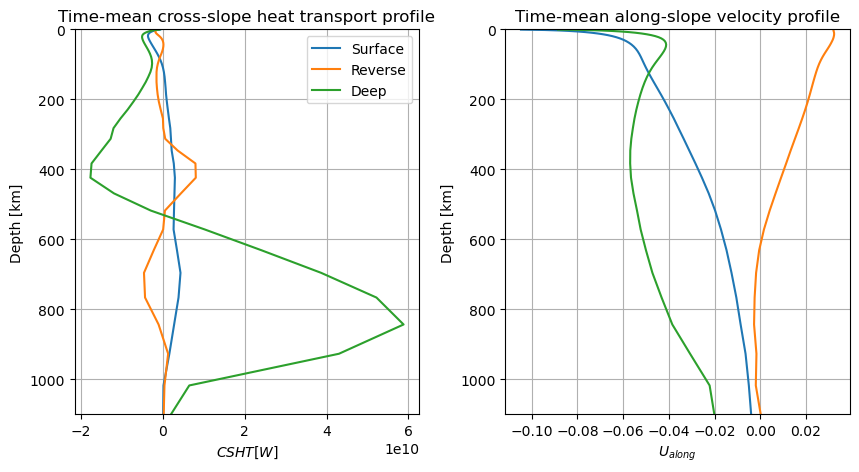

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[0])
masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[1])
masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[2])

# (masked_CSHT.isel(regime=0).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
# (masked_CSHT.isel(regime=1).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
# (masked_CSHT.isel(regime=2).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

# for j in range(3):
#     # Compute the power spectral density
#     frequencies, psd = signal.welch(masked_CSHT.isel(regime=j).mean('lon').mean('depth').values, fs=1)
#     axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_title('Time-mean along-slope velocity profile')
axs[1].set_ylim(1100,0)
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('$U_{along}$')

# axs[1].grid()
# axs[1].set_title('Depth-averaged cross-slope heat transport')
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('$CSHT [W]$')

# axs[2].set_title('Power Spectral Density ($CSHT$)')
# axs[2].set_xlabel('Period [Years]')
# axs[2].set_ylabel('Power')
# axs[2].set_xlim(2/12,20)
# axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/CSHT_vs_Ualong_time_mean.png', dpi=300, bbox_inches='tight')
plt.show()


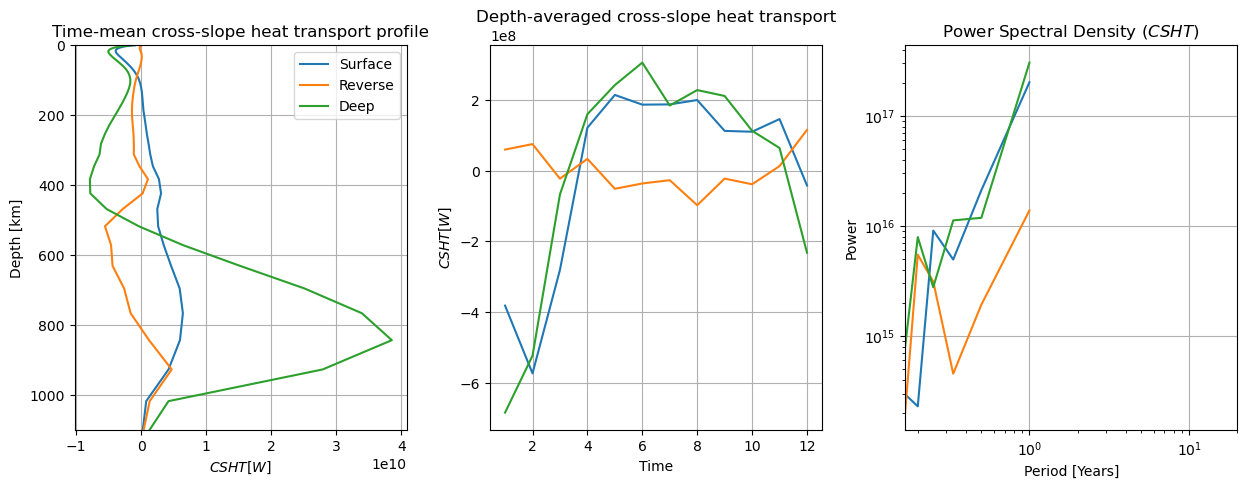

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_CSHT.groupby('time.month').mean('time').isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].grid()
axs[1].set_title('Depth-averaged cross-slope heat transport')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$CSHT [W]$')

axs[2].set_title('Power Spectral Density ($CSHT$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/CSHT_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
## Average over different time scales to get depth-based correlations
CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')

CSHT_layerwise = masked_CSHT.mean('lon')
U_along_layerwise = masked_u_along.mean('lon')

In [38]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_annual = np.zeros((masked_u_along.depth.size, 3))
stderr_annual = np.zeros((masked_u_along.depth.size, 3))
r_sq_annual = np.zeros((masked_u_along.depth.size, 3))
# slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
# stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
# r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))
pval_all = np.zeros((masked_u_along.depth.size, 3))
pval_annual = np.zeros((masked_u_along.depth.size, 3))
pval_clima = np.zeros((masked_u_along.depth.size, 3))

for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        pval_all[j,i] = 1-stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).stderr
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).rvalue**2
        pval_annual[j,i] = 1-stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).pvalue
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).rvalue**2
        pval_clima[j,i] = 1-stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).pvalue



In [39]:
masked_u_along.depth[39:47]

<xarray.DataArray 'depth' (depth: 8)>
array([ 517.624146,  571.589905,  630.727539,  695.424805,  766.066772,
        843.025513,  926.648193, 1017.243713])
Coordinates:
  * depth    (depth) float64 517.6 571.6 630.7 695.4 766.1 843.0 926.6 1.017e+03

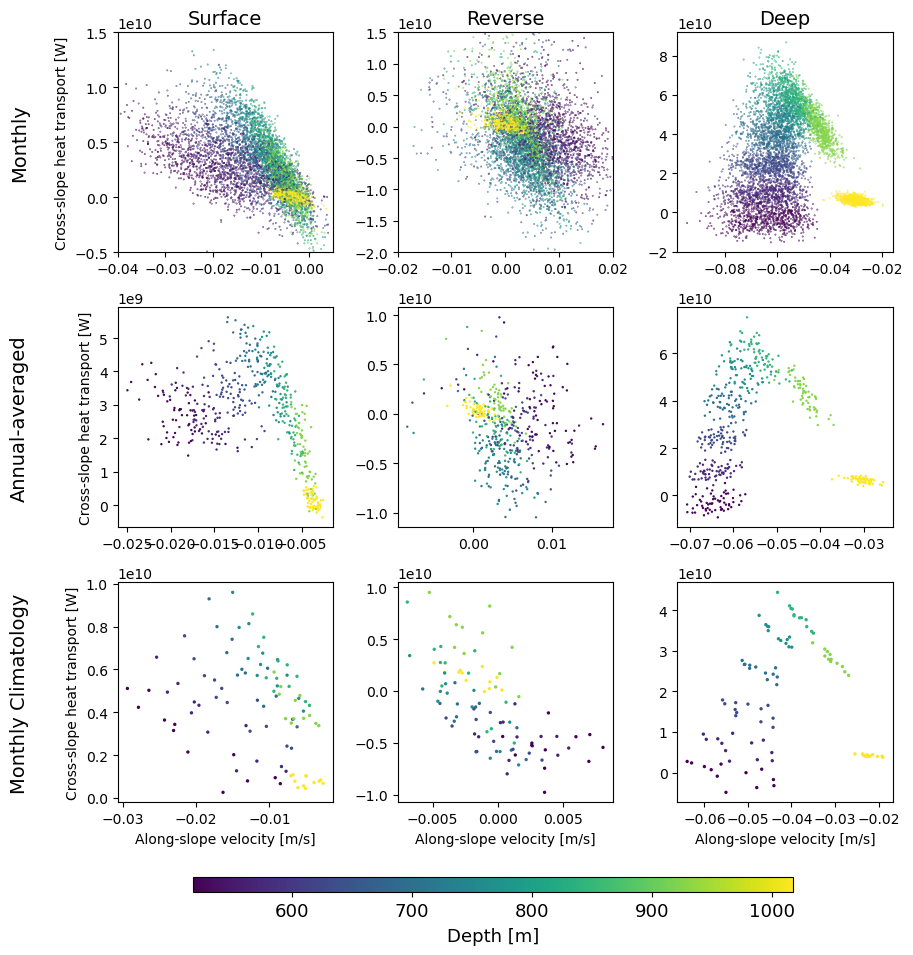

In [40]:
depth_tiled_layerwise = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_layerwise.time.size, axis=0)
depth_tiled_annual = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_annual.year.size, axis=0)
depth_tiled_clima = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_clima.month.size, axis=0)


fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.25, wspace=0.3)

for i in range(3):
    im = axs[i].scatter(U_along_layerwise[:,39:47,i].values.flatten(), CSHT_layerwise[:,39:47,i].values.flatten(), 0.1, c = depth_tiled_layerwise[:,39:47].flatten())
    im = axs[i+3].scatter(U_along_annual[:,39:47,i].values.flatten(), CSHT_annual[:,39:47,i].values.flatten(), 0.5, c = depth_tiled_annual[:,39:47].flatten())
    im = axs[i+6].scatter(U_along_clima[:,39:47,i].values.flatten(), CSHT_clima[:,39:47,i].values.flatten(), 2, c = depth_tiled_clima[:,39:47].flatten())

    axs[i].set_title(classes[i], fontsize=14)
axs[0].set_xlim(-0.04,0.005)
axs[0].set_ylim(-0.5e10,1.5e10)
axs[1].set_xlim(-0.02,0.02)
axs[1].set_ylim(-2e10,1.5e10)
# axs[2].set_xlim(-0.1,0.02)
# axs[2].set_ylim(-2e10,5.5e10)

cbaxes = fig.add_axes([0.2, 0.02, 0.6, 0.015])
cbar = plt.colorbar(im, cax = cbaxes, orientation = 'horizontal')
cbar.set_label(r'Depth [m]', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)

axs[0].text(-0.5,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.5,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.5,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

axs[0].set_ylabel('Cross-slope heat transport [W]')
axs[3].set_ylabel('Cross-slope heat transport [W]')
axs[6].set_ylabel('Cross-slope heat transport [W]')

axs[6].set_xlabel('Along-slope velocity [m/s]')
axs[7].set_xlabel('Along-slope velocity [m/s]')
axs[8].set_xlabel('Along-slope velocity [m/s]')

plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/Scatter_plots_regimes.png', dpi=300, bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


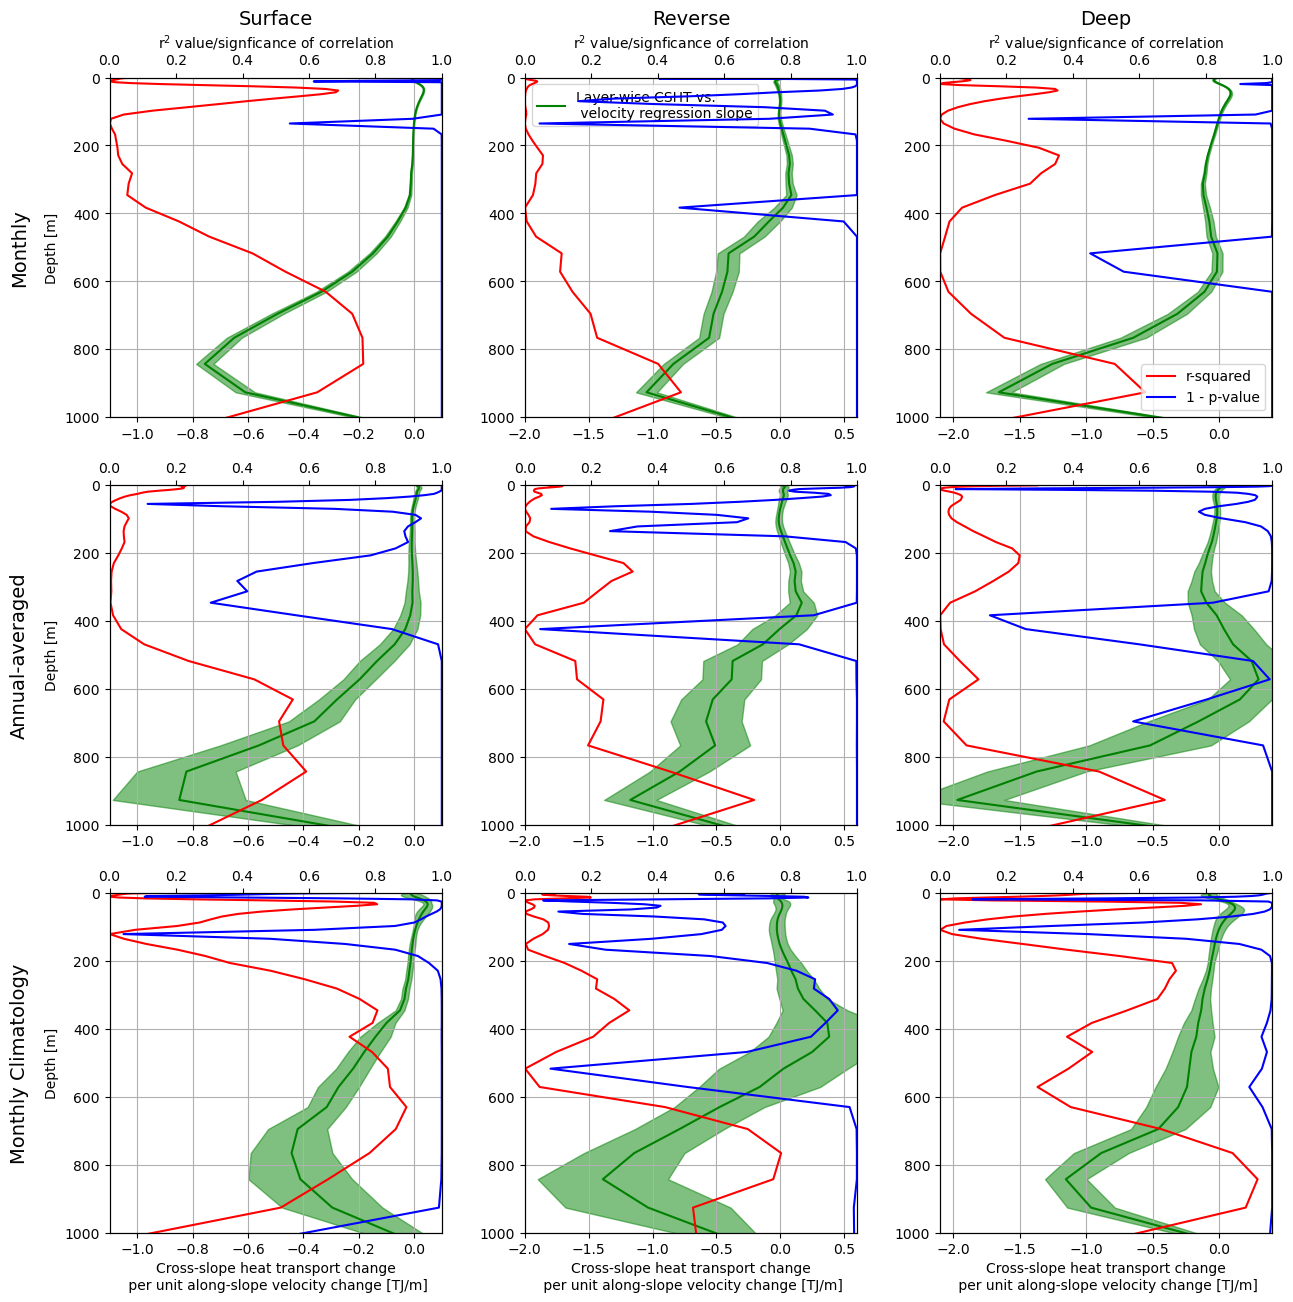

In [41]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( masked_u_along.depth,  slope_annual[:,i]-stderr_annual[:,i]*2, slope_annual[:,i]+stderr_annual[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along.depth,  slope_all[:,i]-stderr_all[:,i]*2, slope_all[:,i]+stderr_all[:,i]*2, alpha=0.5, color='green')
    axs[i+6].plot(slope_clima[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(masked_u_along.depth, slope_clima[:,i]-stderr_clima[:,i]*2, slope_clima[:,i]+stderr_clima[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value/signficance of correlation')
    ax1.plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax1.plot(pval_all[:,i], masked_u_along.depth, 'b', label = '1 - p-value')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax2.plot(pval_annual[:,i], masked_u_along.depth, 'b', label = '1 - p-value')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax3.plot(pval_clima[:,i], masked_u_along.depth, 'b', label = '1 - p-value')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()
    axs[1].legend()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

ax1.legend(loc=4)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/layer_wise_CSHT_vs_U_corr_w_zonalconv.png', bbox_inches='tight', dpi=300)
plt.show()

In [42]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, n=1)
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)

thickness_np = np.diff(st_edges_ocean)

thickness = xr.DataArray(thickness_np, dims = {'depth':st_ocean.size}, coords={'depth':st_ocean.values})

In [43]:
## Average over different time scales (and U_along over depth) to get depth-based correlations
depth_slice = slice(0,1000)
U_along_annual_depth_avg = (masked_u_along.mean('lon').groupby('time.year').mean('time')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')
U_along_clima_depth_avg = (masked_u_along.mean('lon').groupby('time.month').mean('time')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')
U_along_layerwise_depth_avg = (masked_u_along.mean('lon')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')

In [44]:
slope_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
stderr_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
r_sq_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
slope_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
stderr_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
r_sq_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
slope_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))
stderr_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))

for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        slope_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).slope
        stderr_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).stderr
        r_sq_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).rvalue**2
        slope_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).slope
        stderr_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).stderr
        r_sq_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).rvalue**2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


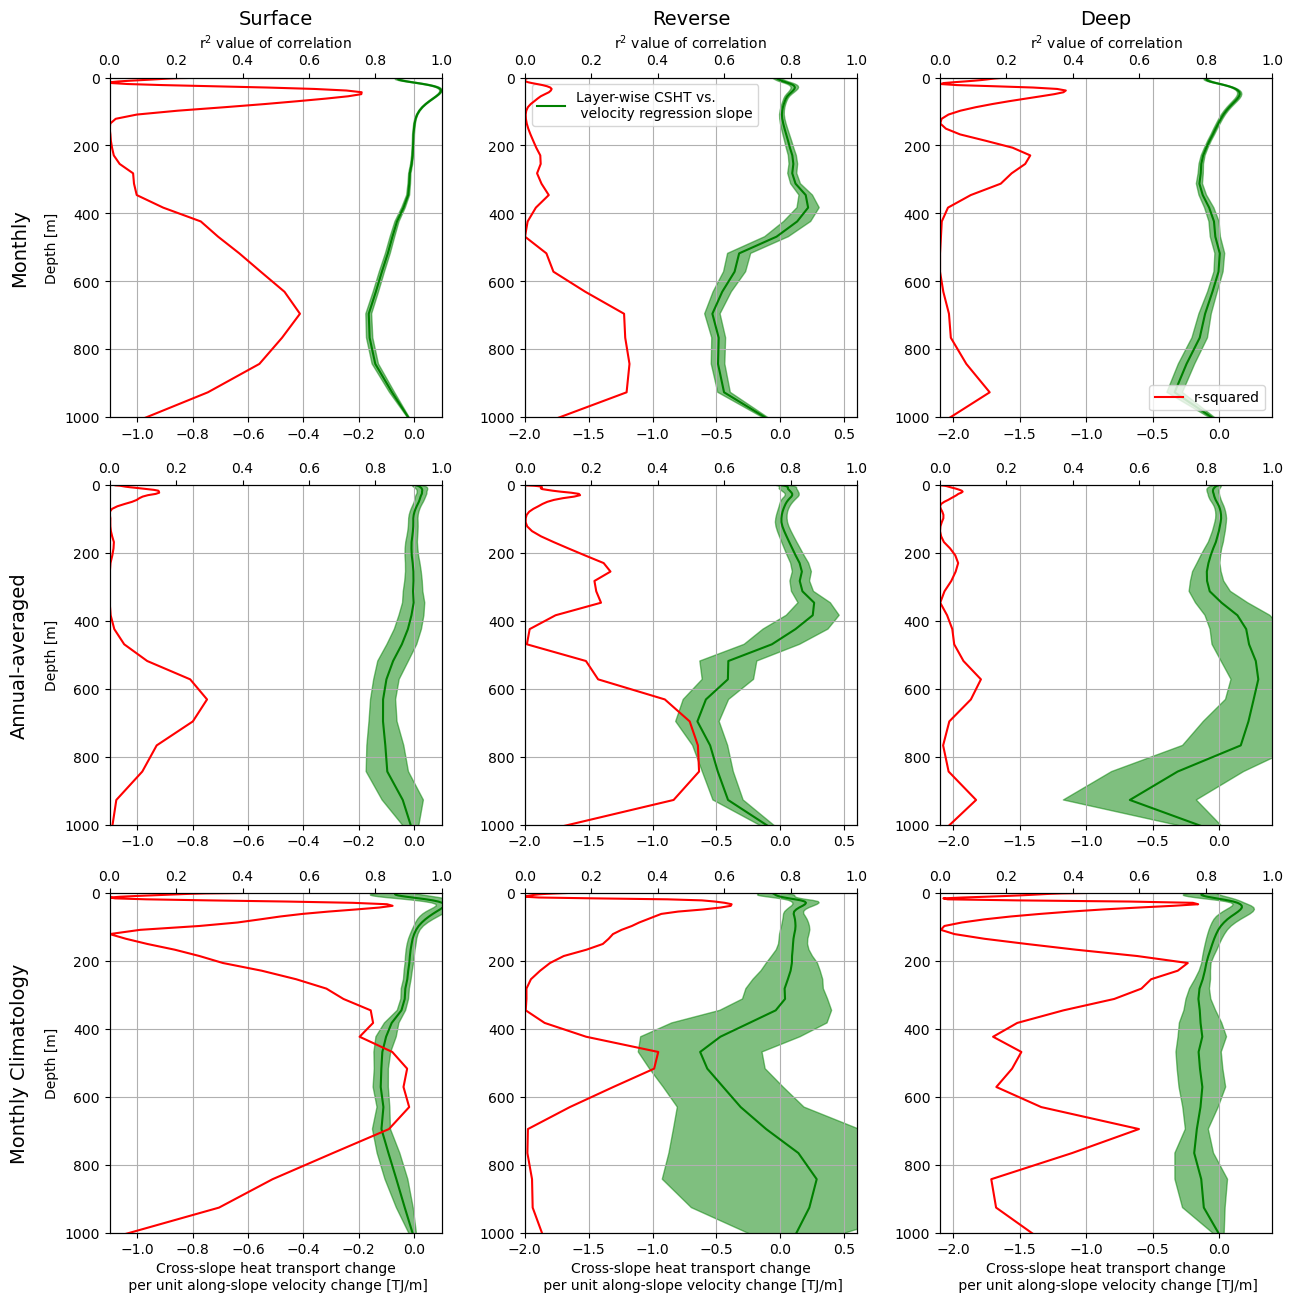

In [45]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( masked_u_along.depth,  slope_annual_depth_avg[:,i]-stderr_annual_depth_avg[:,i]*2, slope_annual_depth_avg[:,i]+stderr_annual_depth_avg[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along.depth,  slope_all_depth_avg[:,i]-stderr_all_depth_avg[:,i]*2, slope_all_depth_avg[:,i]+stderr_all_depth_avg[:,i]*2, alpha=0.5, color='green')
    axs[i+6].plot(slope_clima_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(masked_u_along.depth, slope_clima_depth_avg[:,i]-stderr_clima_depth_avg[:,i]*2, slope_clima_depth_avg[:,i]+stderr_clima_depth_avg[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_all_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    ## For full-depth averaged U_along
    # axs[3*i].set_xlim(-1.1,0.7)
    # axs[3*i+1].set_xlim(-4,2)
    # axs[3*i+2].set_xlim(-3.3,2.1)
    ## For 200-1000m averaged U_along
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()
    axs[1].legend()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

ax1.legend(loc=4)
plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/layer_wise_CSHT_vs_depth_avg_U_corr.png', bbox_inches='tight', dpi=300)
plt.show()

In [41]:
# CSHT_layerwise_lon = masked_CSHT.stack(flat = ['regime','depth', 'lon']).values
# U_along_layerwise_lon = masked_u_along.stack(flat = ['regime','depth', 'lon']).values

# CSHT_annual_lon = masked_CSHT.groupby('time.year').mean('time').stack(flat = ['regime','depth', 'lon']).values
# U_along_annual_lon = masked_u_along.groupby('time.year').mean('time').stack(flat = ['regime','depth', 'lon']).values

# CSHT_clima_lon = masked_CSHT.groupby('time.month').mean('time').stack(flat = ['regime','depth', 'lon']).values
# U_along_clima_lon = masked_u_along.groupby('time.month').mean('time').stack(flat = ['regime','depth', 'lon']).values

In [42]:
# slope_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# slope_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# slope_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))

# for i in tqdm(range(CSHT_layerwise_lon.shape[1])):
#         if np.size(U_along_layerwise_lon[:,i][~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]) >0:
#             slope_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).slope
#             stderr_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).stderr
#             r_sq_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).rvalue**2
#         if np.size(U_along_annual_lon[:,i][~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]) >0:
#             slope_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).slope
#             stderr_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).stderr
#             r_sq_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).rvalue**2
#         if np.size(U_along_clima_lon[:,i][~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]) >0:
#             slope_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).slope
#             stderr_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).stderr
#             r_sq_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).rvalue**2

In [43]:
# slope_all_lon_2D = xr.DataArray(slope_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                 dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                 coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_all_lon_2D = xr.DataArray(stderr_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                  dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                  coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_all_lon_2D = xr.DataArray(r_sq_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# slope_annual_lon_2D = xr.DataArray(slope_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                    coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_annual_lon_2D = xr.DataArray(stderr_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                     dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                     coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_annual_lon_2D = xr.DataArray(r_sq_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                   dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                   coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# slope_clima_lon_2D = xr.DataArray(slope_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                   dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                   coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_clima_lon_2D = xr.DataArray(stderr_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                    coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_clima_lon_2D = xr.DataArray(r_sq_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                  coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})

In [44]:
# slope_all_lon_masked = (slope_all_lon_2D).mean('lon')/1e12
# stderr_all_lon_masked = (stderr_all_lon_2D).mean('lon')/1e12
# r_sq_all_lon_masked = (r_sq_all_lon_2D).mean('lon')/1e12
# slope_annual_lon_masked = (slope_annual_lon_2D).mean('lon')/1e12
# stderr_annual_lon_masked = (stderr_annual_lon_2D).mean('lon')/1e12
# r_sq_annual_lon_masked = (r_sq_annual_lon_2D).mean('lon')/1e12
# slope_clima_lon_masked = (slope_clima_lon_2D).mean('lon')/1e12
# stderr_clima_lon_masked = (stderr_clima_lon_2D).mean('lon')/1e12
# r_sq_clima_lon_masked = (r_sq_clima_lon_2D).mean('lon')/1e12